In [1]:
from collections import OrderedDict, defaultdict
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('dark_background')

In [2]:
from get_observed import get_samples
from heston import infer_heston_parameters, Heston

In [3]:
STOCK_NAME = "MSFT"
START = datetime(2015, 1, 1)
END = datetime(2024, 1, 1)
PREDICITON_PERIOD = 90
NUM_SAMPLES = 1000
NUM_SIMULATIONS = 64
NUM_PLOTS = 9
DT = 1
INTERVAL = "1d"
LOCAL_WINDOW_SIZE = 5

In [4]:
trajectories = get_samples(STOCK_NAME, START, END, PREDICITON_PERIOD, interval=INTERVAL, local_window_size=LOCAL_WINDOW_SIZE, sample_size=NUM_SAMPLES)

[*********************100%***********************]  1 of 1 completed


In [5]:
actual_and_predictions = []

for trajectory in trajectories:
    parameters = infer_heston_parameters(trajectory)
    heston = Heston(**parameters)
    predictions = heston.predict(trajectory, num_simulations=NUM_SIMULATIONS, dt=DT)

    actual_and_predictions.append((trajectory, predictions))

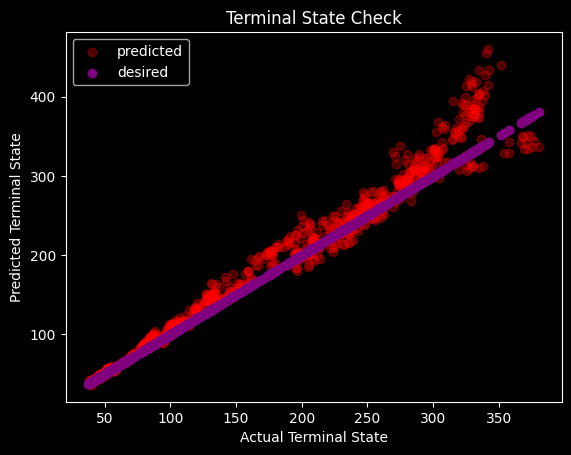

In [6]:
# Terminal State Check

actual_terminals, predicted_terminals = OrderedDict(), OrderedDict()

for actual, predictions in actual_and_predictions:
    actual_terminal_state = actual.iloc[-1]["S"]
    predicted_terminal_states = predictions[-1, ..., 0]
    actual_terminals[actual.index[0].date()] = actual_terminal_state
    predicted_terminals[actual.index[0].date()] = predicted_terminal_states.numpy().mean()

plt.scatter(actual_terminals.values(), predicted_terminals.values(), label="predicted", color="red", alpha=.3)
plt.scatter(actual_terminals.values(), actual_terminals.values(), label="desired", color="purple")
plt.xlabel("Actual Terminal State")
plt.ylabel("Predicted Terminal State")
plt.legend()
plt.title("Terminal State Check")
plt.show()

px.scatter(
    pd.DataFrame({"actual terminal state": actual_terminals, "mean predicted terminal state": predicted_terminals}),
    template="plotly_dark",
    title="Terminal State Check"
)


$$ \operatorname{d}S_t = rS_t\operatorname{d}t + \sqrt{\nu_t}S_t\operatorname{d}W^1_t $$
$$ \operatorname{d}\nu_t = \eta(\theta-\nu_t)\operatorname{d}t + \xi\sqrt{\nu_t}\operatorname{d}W^2_t $$

$$ S_{t_{n+1}}-S_{t_n} = rS_{t_n}(t_{n+1}-t_n) + \sqrt{\nu_{t_n}}S_{t_n}\sqrt{(t_{n+1}-t_n)}\mathcal{N}(0, 1) $$
$$ \nu_{t_{n+1}}-\nu_{t_n} = \eta(\theta-\nu_{t_n})(t_{n+1}-t_n) + \xi\sqrt{\nu_{t_n}}\sqrt{(t_{n+1}-t_n)}\mathcal{N}(0, 1) $$

$$ \mathbb{E}\left[\frac{S_{t_{n+1}}-S_{t_n}}{S_{t_n}(t_{n+1}-t_n)}\right] = r $$
$$ \mathbb{E}\left[\frac{\nu_{t_{n+1}}-\nu_{t_n}}{(\theta-\nu_{t_n})(t_{n+1}-t_n)}\right] = \eta $$
$$ \operatorname{std}\left[\frac{\nu_{t_{n+1}}-\nu_{t_n}-\eta(\theta-\nu_{t_n})(t_{n+1}-t_n)}{\sqrt{\nu_{t_n}(t_{n+1}-t_n)}}\right] = \xi $$
$$ \operatorname{var}\left[\frac{S_{t_{n+1}}-S_{t_n}-rS_{t_n}(t_{n+1}-t_n)}{S_{t_n}\sqrt{t_{n+1}-t_n}}\right] = \nu_{t_n}$$

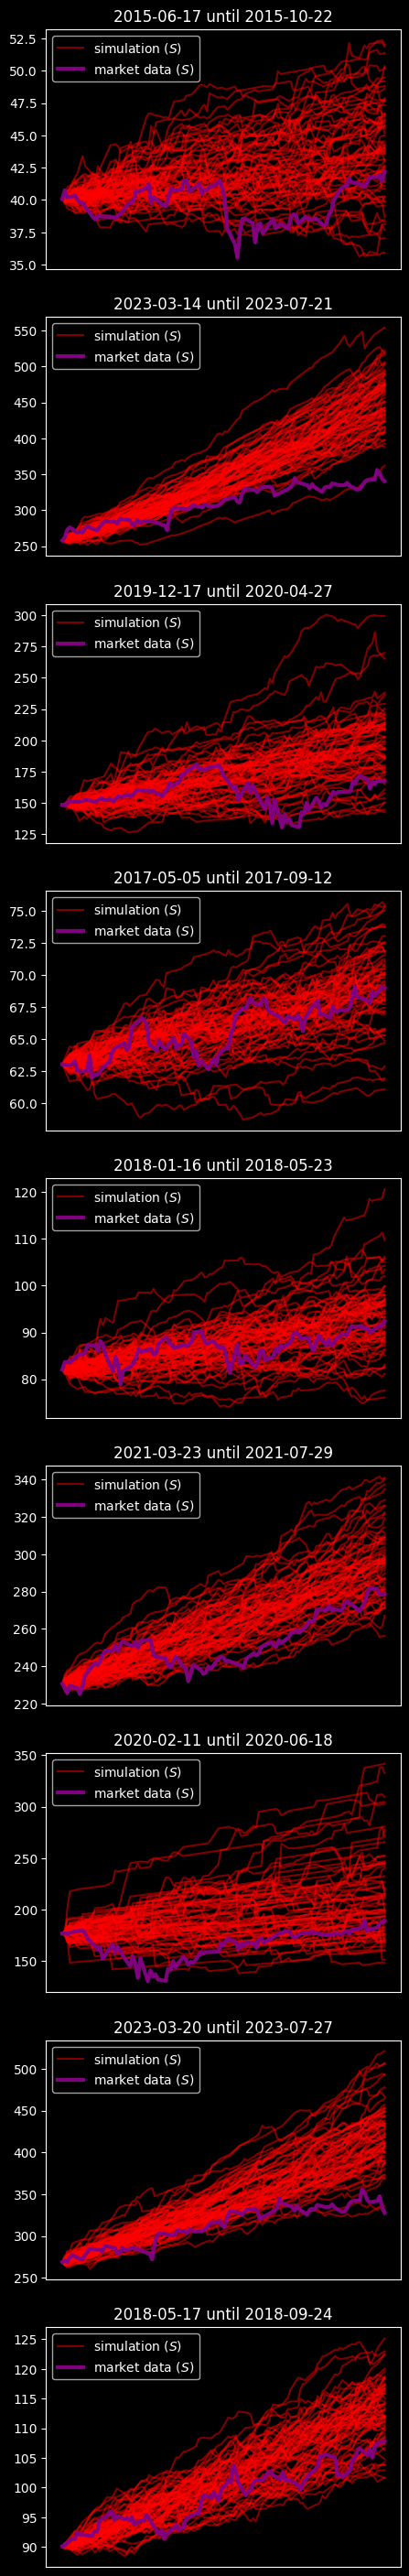

In [10]:
fig, axs = plt.subplots(NUM_PLOTS, 1)
fig.set_size_inches(5, 4 * NUM_PLOTS)

for i, (actual, predictions) in enumerate(actual_and_predictions[:NUM_PLOTS]):
    for j, prediction in enumerate(predictions[..., 0].transpose(0, 1)):
        axs[i].plot(actual.index, prediction.detach(), c="red", alpha=.5, label="simulation ($S$)" if j == 0 else None)
    axs[i].plot(actual.index, list(actual["S"]), c="purple", linewidth=3, label="market data ($S$)")
    axs[i].set_title(f"{actual.index[0].date()} until {actual.index[-1].date()}")
    axs[i].legend()
    axs[i].set_xticks([])

plt.show()

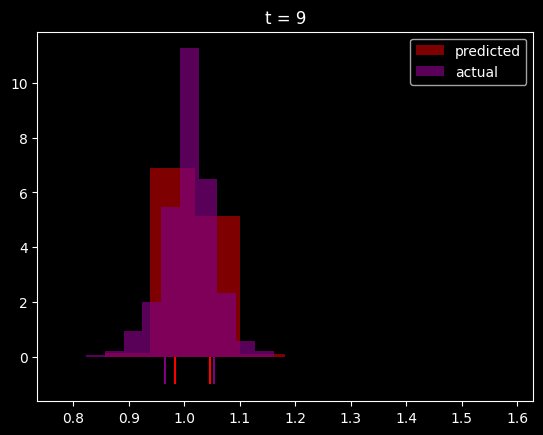

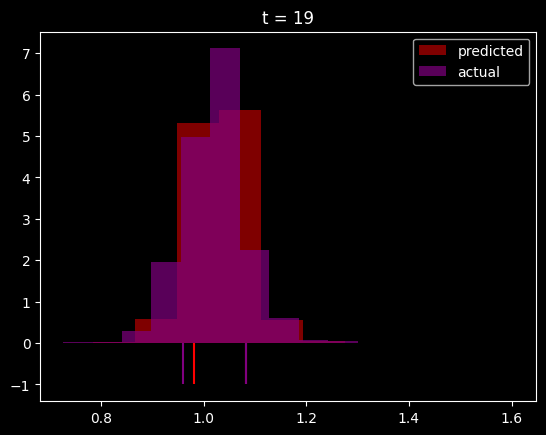

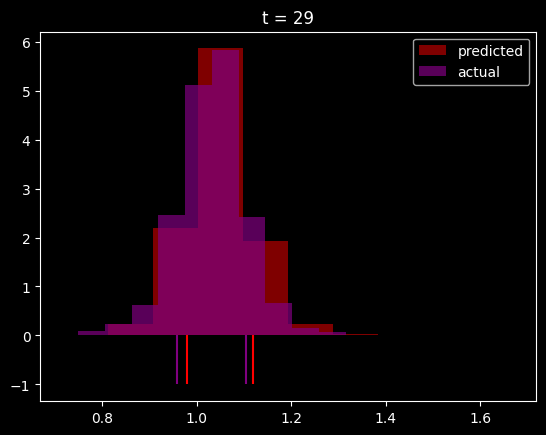

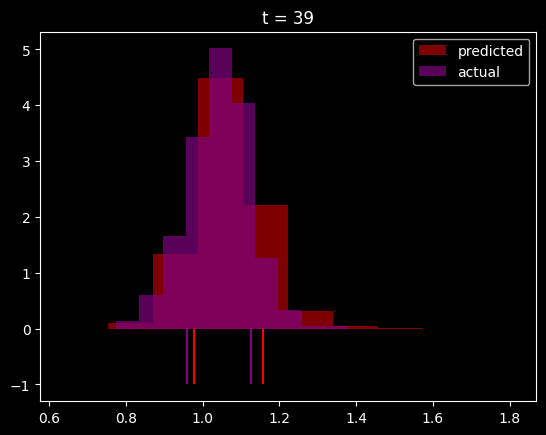

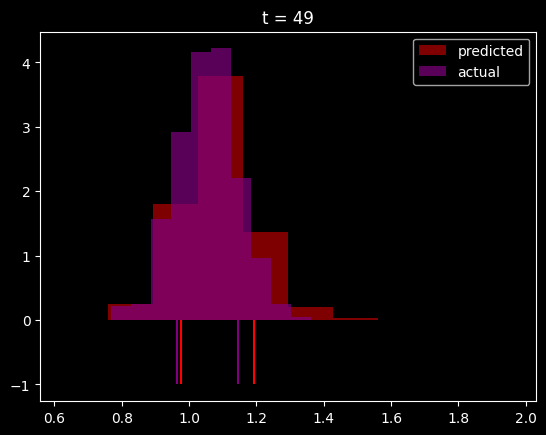

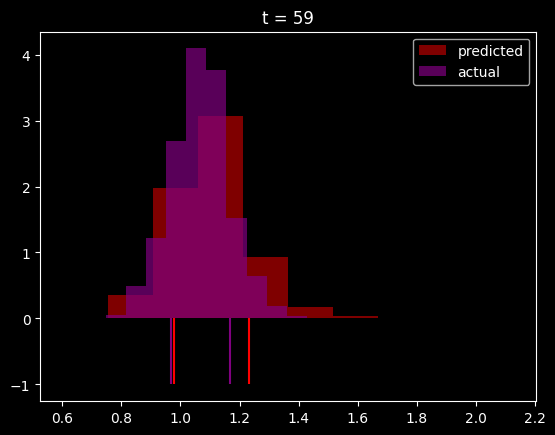

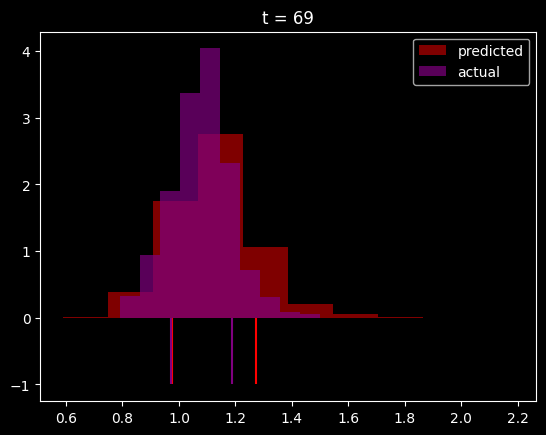

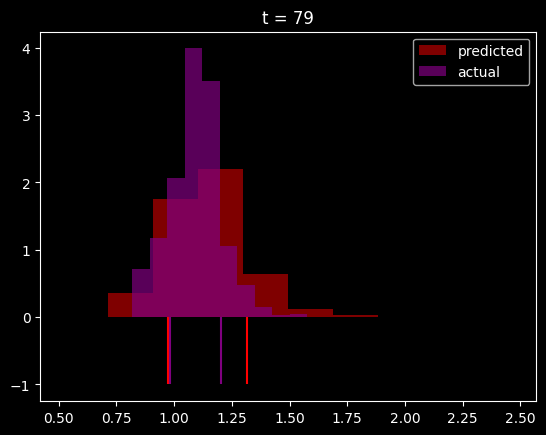

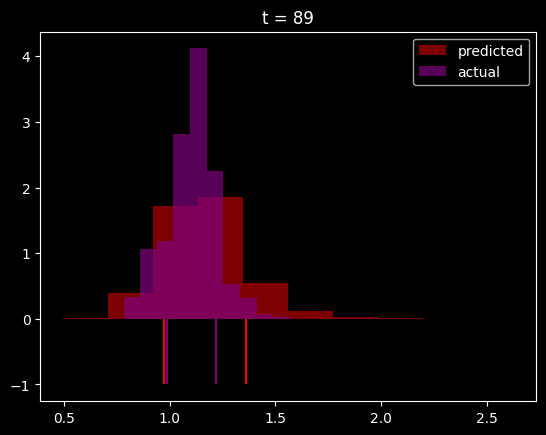

In [8]:
# VARIANCE CHECK

actual_distribution, predicted_distribution = defaultdict(list), defaultdict(list)
time_range = range(9, PREDICITON_PERIOD, 10)

for actual, predictions in actual_and_predictions:
    actual, predictions = np.array(actual["S"]), predictions[..., 0]
    actual, predictions = actual / actual[0], predictions / predictions[0]
    for t in time_range:
        actual_distribution[t].append(actual[t])
        predicted_distribution[t].extend(predictions[t])

def vlines(distribution):
    mean = np.mean(distribution)
    std = np.std(distribution)
    return [mean - std, mean, mean + std]


for t in time_range:
    plt.hist(predicted_distribution[t], histtype="stepfilled", density=True, color="red", alpha=.5, label="predicted")
    plt.vlines(vlines(predicted_distribution), ymin=-1, ymax=0, color="red")
    plt.hist(actual_distribution[t], histtype="stepfilled", density=True, color="purple", alpha=.7, label="actual")
    plt.vlines(vlines(actual_distribution), ymin=-1, ymax=0, color="purple")
    plt.title(f"t = {t}")
    plt.legend()
    plt.show()